In [1]:
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)

/kaggle/input/covid19-dataset/Covid Data.csv


# COVID-19 comorbidities.

### Goals: 
1. Determine important variables and models associated with death of COVID19.
2. Predict patients who are at-risk of death
    
    
### Columns:
The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- __sex__: 1 for female and 2 for male.
- __age__: of the patient.
- __classification__: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees.
    - 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- __patient type__: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- __pneumonia__: whether the patient already have air sacs inflammation or not.
- __pregnancy__: whether the patient is pregnant or not.
- __diabetes__: whether the patient has diabetes or not.
- __copd__: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- __asthma__: whether the patient has asthma or not.
- __inmsupr__: whether the patient is immunosuppressed or not.
- __hypertension__: whether the patient has hypertension or not.
- __cardiovascular__: whether the patient has heart or blood vessels related disease.
- __renal chronic__: whether the patient has chronic renal disease or not.
- __other disease__: whether the patient has other disease or not.
- __obesity__: whether the patient is obese or not.
- __tobacco__: whether the patient is a tobacco user.
- __usmr__: Indicates whether the patient treated medical units of the first, second or third level.
- __medical unit__: type of institution of the National Health System that provided the care.
- __intubed__: whether the patient was connected to the ventilator.
- __icu__: Indicates whether the patient had been admitted to an Intensive Care Unit.
- __date died__: If the patient died indicate the date of death, and 9999-99-99 otherwise.
- __has_died__: Added column. If patient is deceased or not.

__Note: In the Boolean features, 1 means "yes" and 2 means "no". values as 97/98/99 are missing data.__"

In [2]:
def clean_covid_data(file_path: str) -> pd.DataFrame:
    """
    Applies transformations/processcing to raw dataset based on previous EDA.

    Arguments:
        file_path (str): path to csv file
    Returns:
        df (pd.DataFrame): dataframe containing cleaned dataset
    """
    
    df = pd.read_csv(file_path)

    # Make all columns lowercase
    df.columns = df.columns.str.lower()

    # Boolean mask set to where date is not equal to '9999-99-99' (provides boolean basis to create 'has_died' column)
    mask_valid_dates = df['date_died'] != '9999-99-99'

    # Create has_died column based off boolean mask and drop date_died column
    df['has_died'] = mask_valid_dates.astype(int)
    df.drop(columns=['date_died'], inplace=True)

    # Get categorical_cols to use for EDA
    # Categorical_cols are columns besides age since age is continuous
    categorical_cols = df.columns.difference(['age'])

    # Replace all values of 97/98/99 with NA
    df.replace({97: pd.NA, 98: pd.NA, 99: pd.NA}, inplace=True)

    # Get binary_cols (subset of categorical_cols) for later EDA/data preprocessing
    # clasiffication_final and medical_unit are excluded since they have more than 2 categories
    binary_cols = categorical_cols.difference(['clasiffication_final', 'medical_unit'])

    # Replace '2' values as '0' for binary_cols
    df[binary_cols] = df[binary_cols].replace({2: 0})

    # Create multiclass_cols for EDA
    multiclass_cols = categorical_cols.difference(binary_cols)

    # Create num_medical_conditions column
    df['num_medical_conditions'] = df[['pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 'hipertension',
                                        'other_disease', 'cardiovascular', 'obesity', 'renal_chronic']].sum(axis=1)

    # Set null in pregnant to 0 if row contains male
    df.loc[(df['pregnant'].isna()) & (df['sex'] == 0), 'pregnant'] = 0

    # Drop all rows that contain a null
    df.dropna(inplace=True)

    return df


In [3]:
df = clean_covid_data(file_path)
df

,usmer,medical_unit,sex,patient_type,intubed,pneumonia,age,pregnant,diabetes,copd,...,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,has_died,num_medical_conditions
2,0,1,0,0,1,0,55,0,1,0,...,0,0,0,0,0,0,3,0,1,1
5,0,1,1,0,0,1,40,0,0,0,...,0,0,0,0,0,0,3,0,0,1
8,0,1,1,0,0,0,37,0,1,0,...,1,0,0,1,0,0,3,0,0,3
9,0,1,1,0,0,0,25,0,0,0,...,0,0,0,0,0,0,3,0,0,0
11,0,1,0,0,0,0,24,0,0,0,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048553,0,13,1,0,0,1,61,0,1,0,...,1,0,0,0,0,0,7,0,0,3
1048554,0,13,1,0,0,1,63,0,0,0,...,0,0,0,1,0,0,7,0,0,3
1048567,1,13,1,0,0,0,23,0,1,0,...,0,0,0,1,0,0,7,0,0,2
1048569,1,13,1,0,0,0,56,0,1,0,...,0,0,0,0,0,0,7,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 189112 entries, 2 to 1048571
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   usmer                   189112 non-null  int64 
 1   medical_unit            189112 non-null  int64 
 2   sex                     189112 non-null  int64 
 3   patient_type            189112 non-null  int64 
 4   intubed                 189112 non-null  object
 5   pneumonia               189112 non-null  object
 6   age                     189112 non-null  object
 7   pregnant                189112 non-null  object
 8   diabetes                189112 non-null  object
 9   copd                    189112 non-null  object
 10  asthma                  189112 non-null  object
 11  inmsupr                 189112 non-null  object
 12  hipertension            189112 non-null  object
 13  other_disease           189112 non-null  object
 14  cardiovascular          189112 non-null 

# EDA with ydata_profiling, ProfileReport 

note: the output of the profile report is rendered in html

In [5]:
profile = ProfileReport(df, title="Covid Data Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Exploratory Graphs to Identify Relationships

When investigating the predictive power of various factors on the outcome of death versus survival, EDA plays a fundamental role in identifying key variables and understanding their impact.

One of the primary reasons for conducting EDA is to visually explore the distribution and relationships of variables, particularly in relation to the outcome variable of interest. In our case, we were interested in understanding how different variables or conditions might influence the likelihood of a patient succumbing to COVID-19 (death).

Bar graphs focused on calculated odds are an effective visualization tool for categorical variables, making them an excellent choice for exploring the relationship between variables. By plotting the odds of individuals that have died with a positive occurrence of a specific variable and the odds of individuals that have died without a positive occurrence of a specific variable, we can get a baseline understanding if there exists an association/effect between a variable and an outcome. If the heights of these two bar graphs, are approximately the same, then we can reasonably say that there is no effect/association between the variable and the outcome (odds are similar and due to random chance). If the heights of the two bar graphs are different, then you can reasonably say that there may exist an effect/association between the variable and outcome (odds are different).

In the subsequent analysis, we delved deeper into these findings, focusing on variables that showed the most pronounced differences in mortality rates. By investigating these variables more closely, we aimed to gain a deeper understanding of their potential impact on the outcome of interest and inform our selection of features for inclusion in our predictive model.

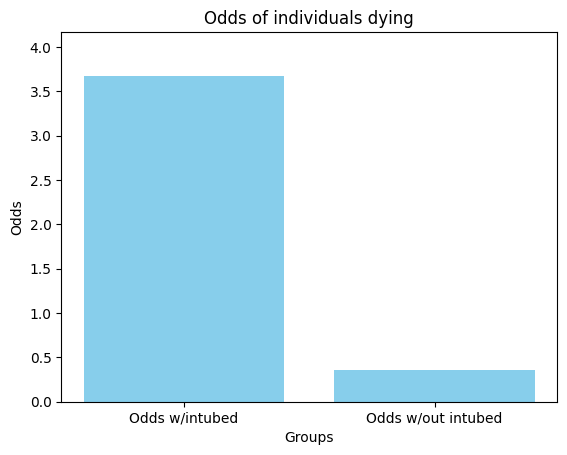

Odds of dying with intubed : 3.6678956324446967
Odds of dying without intubed : 0.35216510552833424


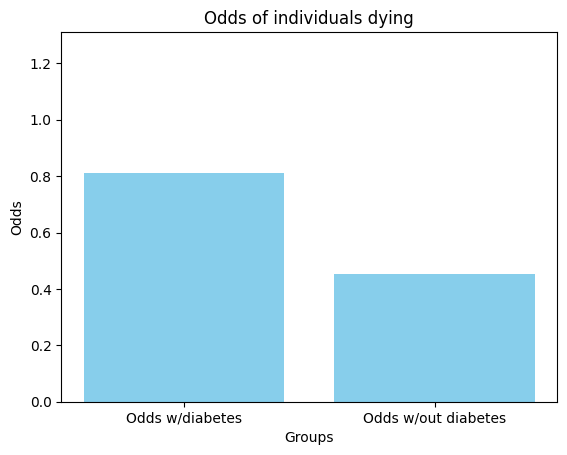

Odds of dying with diabetes : 0.8105022831050228
Odds of dying without diabetes : 0.4536809348682349


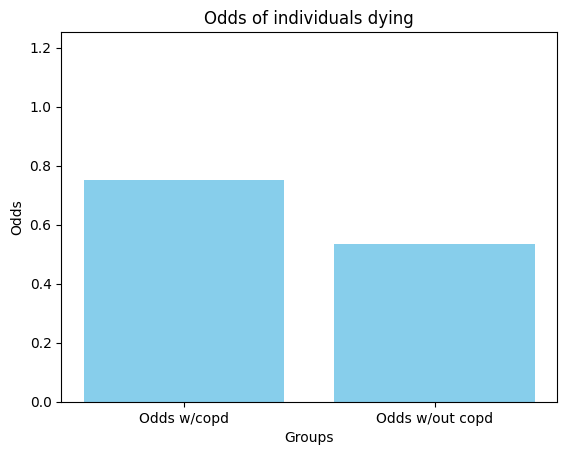

Odds of dying with copd : 0.7526338893766462
Odds of dying without copd : 0.5348445047029913


In [6]:
def calculate_death_odds(variable: str, df: pd.DataFrame):
    """
    Calculates the odds of death with and without the specified variable.
    
    Args:
        variable (str): categorical variable to compare odds
        df (pd.DataFrame): dataframe containing all data
    Returns:
        none
    """
    # Odds of death with and without the variable
    odds_with = df.loc[(df[variable] == 1) & (df['has_died'] == 1), 'has_died'].sum() / \
                df.loc[(df[variable] == 1) & (df['has_died'] == 0), 'has_died'].count()
    
    odds_without = df.loc[(df[variable] == 0) & (df['has_died'] == 1), 'has_died'].sum() / \
                   df.loc[(df[variable] == 0) & (df['has_died'] == 0), 'has_died'].count()
    
    # Bar plot
    bar_data = [odds_with, odds_without]
    plt.bar(['Odds w/' + variable, 'Odds w/out ' + variable], bar_data, color='skyblue')
    plt.title('Odds of individuals dying')
    plt.xlabel('Groups')
    plt.ylabel('Odds')
    plt.ylim(0, max(bar_data) + 0.5)
    plt.show()
    
    print("Odds of dying with", variable, ":", odds_with)
    print("Odds of dying without", variable, ":", odds_without)


calculate_death_odds('intubed', df)
calculate_death_odds('diabetes', df)
calculate_death_odds('copd', df)


Through EDA using bar graphs, we were able to identify notable differences in mortality odds across different features. To assess the strength of the association between the variables and the outcome of interest (death vs. survival), we considered both the visual difference in bar heights and the context of the variables. A strong effect was indicated by a large discrepancy in the odds of deaths between the two groups (dying with a positive instance of a variable vs. dying without a positive instance of a variable). Conversely, a weak association would be suggested by bars that are approximately even in height across the two groups, indicating that the condition does not have a substantial impact on the death outcome (the odds being the similar or the same).

The three variables we were interested in were diabetes, intubed, and copd.

For diabetes, we see that that odds of individuals that have died with diabetes versus without diabetes was 0.81 vs 0.45. This difference suggests that having diabetes has an effect on increasing the odds of an individual dying. Looking at intubed, we see that the odds of individuals that have died that were intubed versus not being intubed was 3.67 vs 0.35. This large difference suggests a very strong effect on increasing the odds of an individual dying. For copd, we see that the odds of individuals that have died with copd versus without copd was 0.75 versus 0.53. This is the smallest difference and suggests that while copd may increase the odds of dying, that effect may not be as strong as the first two.

These visualizations allowed us to build more insight as to which variables might have a significant impact on the outcome of death and helped guide further analysis and the selection of features for predictive modeling, focusing on those with stronger associations for more accurate predictions.

# Logistic Regression

### Logistic Regression Assumptions to Consider:

1.  **Dependent/response variable is binary**
    -   Yes. Died (1) versus has not died (0).
2.  **Little or no multicollinearity between the predictor/explanatory variables**
    -   Multicollinearity does exist. 
3.  **Linear relationship of independent variables to log odds**
    -   As out data is virtually ALL binary, categorical data, we cannot check this assumption for the majority of our data.
4.  **Prefers large sample size**
    -   Yes, even with omitting NULLs, the dataset is about \~189,000 rows long.
5.  **Problem with extreme outliers**
    -   None identified. Age, the only column with outliers, follows a relatively normal distribution.
6.  **Independent observations**
    -   Yes, assuming independence of individual outcomes. It is reasonable to say that one person's death should not affect another's.

In [7]:
# get data ready for ML

X = df[[col for col in df.columns if col != 'has_died']]
y = df['has_died']

# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# numeric features
numeric_features = [col for col in df.columns if col != 'has_died']

In [8]:
# Logistic Regression

lr = LogisticRegression(max_iter=1000)

# train !
lr.fit(X_train, y_train)

# get results and test
y_pred = lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83     24353
           1       0.75      0.50      0.60     13470

    accuracy                           0.76     37823
   macro avg       0.76      0.70      0.71     37823
weighted avg       0.76      0.76      0.75     37823



In [9]:
def feature_coefficients(feature_names: list, feature_coefficients: list):
    """
    Returns dataframe containing the feature coefficients
    
    Args:
        feature_names (list): list of feature names
        feature_coefficients (list): list of coefficients
    Returns:
        df (pd.DataFrame): dataframe containing feature coefficeint values
    """
    df = pd.DataFrame({'feature': feature_names, 'coefficient': feature_coefficients})
    df = df.assign(abs_coef=lambda x: x['coefficient'].abs())
    df = df.sort_values(by='abs_coef', ascending=False)[['feature', 'coefficient']]
    
    return df

# Inference:

Top 3 Variables that increase a patient's odds of death:

In [10]:
feature_names = X.columns
coef = list(lr.coef_.flatten())

# top 3 coefficeints (odds ratio)
feature_coefficients(feature_names, coef).sort_values(by='coefficient', ascending=False).iloc[:3]

,feature,coefficient
4,intubed,2.372052
5,pneumonia,0.488814
16,renal_chronic,0.251774


1.  **Intubated**
    - Coefficient: Coefficient (Estimate) of 2.37. Indication that when a patient is intubated, the log odds of dying are increased by approximately 2.37, compared to when they are not intubated.
    - Odds Ratio (OR): e^2.37, indicating the odds of death are 10.7 times greater for patients who are intubated vs. not.
2.  **Pneumonia**
    - Coefficient: Coefficient (Estimate) of 0.49. Indication that when a patient has pneumonia, the log odds of dying are increased by approximately 0.49, compared to when they do not have pneumonia.
    - Odds Ratio (OR): e^0.49, indicating the odds of death are 1.6 times greater for patients who have pneumonia vs. not.
3.  **Renal Chronic**
    - Coefficient: Coefficient (Estimate) of 0.25. Indication that when a patient has chronic renal disease, the log odds of dying are increased by approximately 0.25, compared to when they do not have the disease.
    - Odds Ratio (OR): e^0.25, indicating the odds of death are 1.3 times greater for patients with chronic renal disease vs those who do not.

# Models for Binary Classification 

1. Logistic Regression
2. XGBoost
3. Random Forrest

In [11]:
# create the generic pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

In [12]:
# Logistic Regression classifier

# Full pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

# Training the model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred = lr_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83     24353
           1       0.75      0.50      0.60     13470

    accuracy                           0.76     37823
   macro avg       0.76      0.70      0.71     37823
weighted avg       0.76      0.76      0.75     37823



In [13]:
# XGBoost classifier

# Full pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb.XGBClassifier())])

# Training the model
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_pred = xgb_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83     24353
           1       0.74      0.56      0.63     13470

    accuracy                           0.77     37823
   macro avg       0.76      0.72      0.73     37823
weighted avg       0.77      0.77      0.76     37823



In [14]:
# Random Forrest classifier


# Full pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

# Training the model
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80     24353
           1       0.65      0.56      0.60     13470

    accuracy                           0.74     37823
   macro avg       0.71      0.70      0.70     37823
weighted avg       0.73      0.74      0.73     37823



# Best Performing Model: XGBoost Classifier

**Accuracy:** Out of all predictions, returns ratio of how many were predicted correctly 

$$ \text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}} $$

**Precision:** Out of all positive predictions, returns ratio of how many were truly positive 

$$ \text{Precision} = \frac{TP}{TP + FP} $$

**Recall:** Out of all true labels, returns ratio of correctly predicted positives 

$$ \text{Recall} = \frac{TP}{TP + FN} $$

- Overall Performance:
  - __Accuracy:__ 0.77
  - __Precision for Prediction of Death (1):__ 0.74
  - __Recall for Prediction of Death (1):__ 0.56

Looking at the overall performance, we have an accuracy of 0.77, a precision of 0.74, and a recall of 0.56.

This means that overall accuracy across all predictions, we were able to correctly predict 77% of the outcomes of did not die and died. For precision, we see that across all the times we predicted that someone was at risk of death, only 74% of those predictions were correct. For recall, we see that for all truly at-risk patients, we were able to identify about 56% of them correctly. 

Since we are dealing with medical predictions of death, we want to favor recall. In essence, we want to bias towards Type II Errors (False Positives) rather than Type I Errors (False Negatives) since the latter has much more detrimental effects. 

Before, we lower the decescion threshold, we will use Random Search Cross Validation to fine-tune the parameters of the XGBoost Classifier.

# Hyperparamter Tuning

In [15]:
# Define hyperparameters to tune
param_dist = {
    'classifier__learning_rate': uniform(0.01, 0.3),  # Boosting learning rate
    'classifier__n_estimators': randint(100, 1000),   # Number of boosting rounds
    'classifier__max_depth': randint(3, 10),          # Maximum tree depth
}


# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_pipeline,
                                   param_distributions=param_dist,
                                   n_iter=15,
                                   scoring='accuracy',  # Use both accuracy and recall for scoring
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1)


random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'classifier__learning_rate': 0.09619145549020765, 'classifier__max_depth': 3, 'classifier__n_estimators': 933}


In [16]:
# XGBoost classifier w/ decreased deciscion threshold
best_estimator = random_search.best_estimator_

threshold = 0.25  

y_pred_random_search = best_estimator.predict(X_test)

y_pred_proba_random_search = best_estimator.predict_proba(X_test)

y_pred_threshold_random_search = np.where(y_pred_proba_random_search[:,1] > threshold, 1, 0)

# Evaluate 
accuracy_threshold_random_search = accuracy_score(y_test, y_pred_threshold_random_search)
recall_threshold_random_search = recall_score(y_test, y_pred_threshold_random_search)
conf_matrix_threshold_random_search = confusion_matrix(y_test, y_pred_threshold_random_search)
classification_rep_threshold_random_search = classification_report(y_test, y_pred_threshold_random_search)

print("Classification Report with adjusted threshold using RandomizedSearchCV:\n", classification_rep_threshold_random_search)

Classification Report with adjusted threshold using RandomizedSearchCV:
               precision    recall  f1-score   support

           0       0.88      0.62      0.73     24353
           1       0.55      0.85      0.67     13470

    accuracy                           0.70     37823
   macro avg       0.72      0.73      0.70     37823
weighted avg       0.76      0.70      0.70     37823



With a decreased threshold to 0.25 we get:

- Overall Performance:
  - __Accuracy:__ 0.70
  - __Precision for Prediction of Death (1):__ 0.55
  - __Recall for Prediction of Death (1):__ 0.85

Looking at the overall performance at the decreased decescion threshold of 0.25, we have an accuracy of 0.70, a precision of 0.55, and a recall of 0.85.

This means that overall accuracy across all predictions, we were able to correctly predict 70% of the outcomes of did not die and died. For precision, we see that across all the times we predicted that someone was at risk of death, only 55% of those predictions were correct. For recall, we see that for all truly at-risk patients, we were able to identify about 85% of them correctly. 

From a medical perspective, recall is much more important than just simply evaluating off accuracy. We want to identify and capture more truly at-risk patients at the risk of increased False Positives/Type I Errors (decreased accuracy/precision) rather than have False Negatives fall through the cracks.

This is the preferred model. 


# ROC Curve

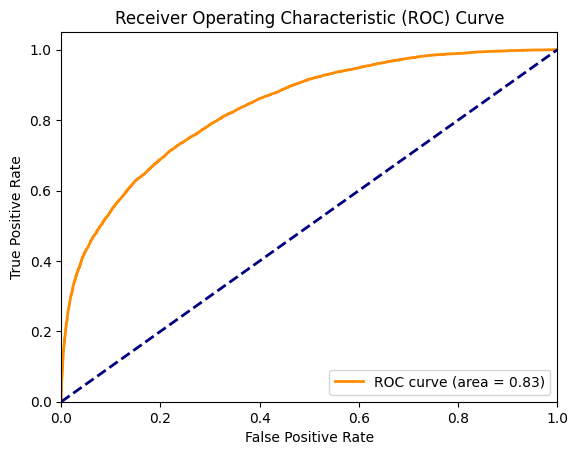

In [17]:
# Calculate the false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_random_search[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [18]:
# Find optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)


Optimal Threshold: 0.3475244


# Final Evaluation:
In binary classification, you can assess the performance of a model by looking at the rate of true positives (sensitivity) and the rate of false positives (1 - specificity) of its predictions. The ROC curve (Receiver Operating Characteristic) graphically represents this relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) with respect to different decision thresholds. In essence, the ROC curve not only gives a visual representation of the binary classification model's performance, but also provides a way to assess how you want choose a threshold based on the requirements of your prediction problem.

The ROC curve has sensitivity [0,1] on the y-axis and 1-specificity [0,1] on the x-axis. The curve on the plot shows TPR vs FPR for different decision thresholds. The solid diagonal line represents an ROC curve that comes from a prediction model that is purely based on random chance.

Therefore, the closer the ROC curve is to the diagonal line, the worse the performance. In addition, in an ideal world where you get 100% TPR and 0% FPR, the ROC curve would "hug" the left/upper part of the graph, forming an elbow at the upper-left corner. Again, this represents perfect performance. With this in mind, the closer the ROC curve is to hugging the graph's upper-left corner, the better the performance since you approach achieving higher TPR values while minimizing the FPR. In the curve below, we see that it's shape approaches the upper left corner which is a positive sign that our model is not predicting randomly but based on the data it was trained on.

In addition to the ROC curve, you can also look at the Area Under the Curve (AUC). This area represents the probability that the model decides that a random positive instance is ranked higher than a random negative instance. It is another way to evaluate the performance of the model. As the model approaches the "ideal upper-left elbow" scenario, the AUC will approach 1. Therefore, AUCs that are closer to 1 are higher performing binary classification models. In our current model, the AUC is 0.83.

For determining the optimal decision threshold, that point occurs where Sensitivity and Specificity are maximized. In the case of the ROC curve below it is the part of the curve that is furthest away from the solid diagonal line. This point maximizes true positive (sensitivity) while minimizing the false positives (1-specificity). However, to get the actual threshold value, we must use a command in R to calculate it based off the ROC curve. Using the ROC curve and specifically, the pROC package, we can use the coords() function. The input parameters are the roc_curve object, the method to detect the best threshold (default with "best" is Youden's J statistic), and then which coordinates to return (threshold). Using this method, we get an optimal threshold of around 0.35.

While we can calculate the optimal decision threshold, our final threshold decision will take more thought and nuance. For assessing how we want to choose the final threshold for our specified prediction problem, we have to understand the trade-off between False Positives (FP) and False Negatives (FN). FPs are predictions with true labels when they are actually false. FNs are predictions of false labels when they are actually true. A binary classification model cannot optimize the threshold for both FPs and FNs. Intuitively this makes sense as increasing the threshold for predicting a positive class will favor FNs over FPs and decreasing the threshold will favor FPs over FNs. Depending on you problem, you will favor one or the other.

Again, to predict the risk factors of death in Covid-19 patients, you want to exercise the most caution. Therefore, you would favor having higher rates of false positives than false negatives since you want to warn more people about their risk even if some are not at risk of death at all. This opposes a high rate of false negatives where you will see more patients with an actual risk who will not be informed that they are at risk. Therefore, for this binary classification model, a higher rate of FP is preferred and with that, a lower decision threshold. 

Therefore, our final model will be a binary classfier using:
1. A Gradient Boosting Classifier (XGBoost)
2. Median Imputation + Scaling
3. Decreased decision threshold of 0.25 (optimal = 0.35)
4. Bias for recall/Type I Errors
